Make a Latin Hypercube of training points, then call CLASS + CLPT to make the y points for it. 

In [1]:
from subprocess import call
from time import time
from itertools import izip
import os
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from collections import OrderedDict
from classy import Class

Compure Latin Hyper Cube, a simple but good sampling scheme. 

In [2]:
np.random.seed(0)
def make_LHC(ordered_params, N):
    """
    Return a vector of points in parameter space that defines a latin hypercube.
    :param ordered_params:
        OrderedDict that defines the ordering, name, and ranges of parameters
        used in the trianing data. Keys are the names, value of a tuple of (lower, higher) bounds
    :param N:
        Number of points per dimension in the hypercube. Default is 500.
    :return
        A latin hyper cube sample in HOD space in a numpy array.
    """
    np.random.seed(int(time()))

    points = []
    # by linspacing each parameter and shuffling, I ensure there is only one point in each row, in each dimension.
    for plow, phigh in ordered_params.itervalues():
        point = np.linspace(plow, phigh, num=N)
        np.random.shuffle(point)  # makes the cube random.
        points.append(point)
    return np.stack(points).T

Compute the power spectra using class.

In [4]:
default_params = {
        'output': 'mPk',
        'ln10^{10}A_s': np.log( (10**10)*2.42e-9),
        'P_k_max_h/Mpc': 100.0,
        'n_s': 0.96,
        'h': 0.7,
        #'non linear': 'halofit',
        'omega_b': 0.022,
        'omega_cdm': 0.1122,
        'z_pk': 0.0}

k_size = 600

def compute_pk(input_params, outputdir):
    """
    Use class to compute the power spectrum as initial conditions for the sims.
    :param input_params:
        Updates to the default parameters for CLASS. 
    :param outputdir:
        Outputdir to store the power specturm. It should be the same as where picola is loaded from.
    :return:
        None
    """

    params = default_params.copy()
    
    #params.update(input_params)

    cosmo = Class()
    cosmo.set(params)

    cosmo.compute()#level = ["initnonlinear"])

    ks = np.logspace(-3, 1.5, k_size).reshape(k_size,1,1)
    zs = np.array([params['z_pk']])

    return cosmo.get_pk(ks, zs, k_size, 1, 1)[:,0,0]
    # I save them here, but you could return as well. 
    #np.savetxt(os.path.join(outputdir, 'class_pk.dat'), np.c_[ks[:,0,0], pks],\
    #           delimiter = ' ')

    #return cosmo.sigma8()



Ignore these grayed out cells. Instead, you should convert pk to matter-matter correlation. 

Ordered params lists the parameters we want to sample, and the bounds we want to sample them in. 

In [5]:
#10x planck 2018 contours
ordered_params = OrderedDict({'omega_b':[0.02233-0.00075,0.02233+0.00075 ],
                  'omega_cdm':[0.1198-0.012/2, 0.1198+0.012/2],
                  'ln10^{10}A_s':[3.043-0.14/2, 3.043+0.14/2],
                  'n_s': [0.96605-0.042/2, 0.96605+0.042/2],
                  'h': [67.37 - 5.4/2, 67.37+5.4/2]})

In [6]:
lhc = make_LHC(ordered_params, 500)

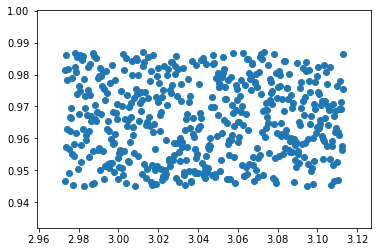

In [7]:
plt.scatter(lhc[:,2], lhc[:,3])

In [8]:
output_dir = './data'

Call this code on our Pks. 

In [ ]:
pk = np.zeros((lhc.shape[0], k_size))

for idx, point in enumerate(lhc):
    point_output_dirname = os.path.join(output_dir, 'point_%03d'%idx)
    if not os.path.isdir(point_output_dirname):
        os.mkdir(point_output_dirname)
    
    params = OrderedDict(izip(ordered_params.keys(), point))
    print params
    pk[idx] = compute_pk(params, point_output_dirname)
    #write_clpt_params(params, point_output_dirname)
    #command = make_kils_command('albert_%03d'%idx, 1, point_output_dirname)
    #call(command, shell = False)

OrderedDict([('h', 68.9878356713427), ('omega_b', 0.022346533066132265), ('ln10^{10}A_s', 3.002178356713427), ('n_s', 0.9485009018036071), ('omega_cdm', 0.12233707414829659)])
OrderedDict([('h', 67.21308617234469), ('omega_b', 0.02236456913827655), ('ln10^{10}A_s', 3.0754048096192386), ('n_s', 0.9647453907815631), ('omega_cdm', 0.12466973947895792)])
OrderedDict([('h', 66.2391382765531), ('omega_b', 0.02244573146292585), ('ln10^{10}A_s', 3.1059859719438876), ('n_s', 0.9690379759519038), ('omega_cdm', 0.11456953907815631)])
OrderedDict([('h', 69.39905811623247), ('omega_b', 0.022989819639278555), ('ln10^{10}A_s', 3.014523046092185), ('n_s', 0.9650820641282565), ('omega_cdm', 0.11654148296593186)])
OrderedDict([('h', 68.93372745490983), ('omega_b', 0.022565971943887774), ('ln10^{10}A_s', 3.079332665330661), ('n_s', 0.9804007014028056), ('omega_cdm', 0.11745531062124248)])
OrderedDict([('h', 68.23032064128257), ('omega_b', 0.022154148296593186), ('ln10^{10}A_s', 3.1115971943887777), ('n_s

This function consolidates the computed functions and puts them into one file. 

It is possible to write them into the output file directly in the first place, hdf5 enables that. 

I was just lazy when I wrote this. 

In [ ]:
from glob import glob
from os import path
import h5py
def consolidate_outputs(directory, ordered_params, lhc,  fname= "xi.hdf5"):
    """
    Take outputs from compute_on_subet and write them to one hdf5 file.
    :param directory:
        The directory with the outputs in them
    """
    output_fnames = sorted(glob(path.join(directory, 'point_*/xi.txt') ) )

    all_output = []
    # i'd like to find a way to make the numpy arrays a priori but not sure how
    n_bins = 0 
    for o_fname in output_fnames:
        output = np.loadtxt(o_fname)
        all_output.append(output)
        n_bins = output.shape[0]

    all_output = np.array(all_output)
    f = h5py.File(path.join(directory, fname), 'w')

    try:

        f.attrs['param_names'] = ordered_params.keys()
        f.attrs['param_vals'] = lhc
        print all_output.shape
        f.attrs['scale_bins'] = all_output[0, :n_bins, 0] #


        for point_no, data in enumerate(all_output):
            group_name = 'point_%03d'%point_no
            grp = f.create_group(group_name)  # could rename the above to the group name

            # I could compute this, which would be faster, but this is easier to read.
            for param_idx, param_name in enumerate(['xi_l', 'xi_0', 'xi_10', 'xi_01', 'xi_20', 'xi_11', 'xi_02']):
                grp.create_dataset(param_name, data=data[:, param_idx+1]\
                                   , chunks=True, compression='gzip')
    finally:
        #print 'hi'
        f.close()
    #f.close()

In [ ]:
consolidate_outputs(output_dir, ordered_params, lhc)

Fomr the hdf5 file get the x,y pairs. 

In [ ]:
def get_data(filename, observable):
    f = h5py.File(filename, 'r')
    _x = f.attrs['param_vals']
    r = f.attrs['scale_bins']
    x = np.zeros((_x.shape[0]*r.shape[0], _x.shape[1]+1))
    y = np.zeros((x.shape[0], ))

    for idx, row in enumerate(_x):
        x[idx*r.shape[0]:(idx+1)*r.shape[0], :-1] = row
        x[idx*r.shape[0]:(idx+1)*r.shape[0], -1] = r
        
        key = 'point_%03d'%idx
        grp = f[key]

        y[idx*r.shape[0]:(idx+1)*r.shape[0]] = grp[observable]
    
    return x, y

In [ ]:
x, y = get_data(path.join(output_dir, 'xi.hdf5')#, 'xi_l')

In [ ]:
import george
from george.kernels import *

Get out an emulator. 

In [ ]:
emulator_ndim = x.shape[1]
metric = np.ones((emulator_ndim+1,))
a = metric[0]
kernel = a * ExpSquaredKernel(metric[1:], ndim=emulator_ndim)+\
            a*Matern32Kernel(metric[1:], ndim=emulator_ndim)+a

emulator = george.GP(kernel)

emulator.compute(x[:-8000]) 

In [ ]:
y_pred = emulator.predict(y[:-8000], x[-8000:, :])[0]

In [ ]:
np.mean(np.abs(np.abs(y_pred - y[-8000:])/y[-8000:]) )